
# Proyecto. Aplicacion de Redes Neuronales

Hernandez Martinez Mally Samira | Código: 220286113 | Ingenieria de computacion (INCO) 

Seminario de Solucion de Problemas de Inteligencia Artificial II | Seccion D05 I7041


<u>Caso de estudio</u>:

Implementación de un clasificador automático de señales de ECG para la detección de arritmias, utilizando la base de datos MIT-BIH. Este sistema está diseñado para identificar automáticamente distintos tipos de arritmias, como el ritmo sinusal normal, contracciones ventriculares prematuras, y otras anomalías del ritmo cardíaco. Su aplicación potencial incluye su uso en sistemas de monitoreo médico en tiempo real para hospitales y dispositivos de telemedicina, permitiendo a los profesionales de la salud realizar un diagnóstico temprano y personalizado. Además, al facilitar una clasificación precisa y rápida, este sistema puede mejorar la accesibilidad a la atención médica remota, optimizando la capacidad de respuesta ante emergencias cardíacas y elevando el nivel de atención para pacientes con enfermedades cardiovasculares.

1.	Preprocesamiento de Datos:

    - Cargar el conjunto de datos de ECG de la base MIT-BIH, que incluye múltiples clases de arritmias (por ejemplo, ritmo sinusal normal, contracción ventricular prematura, entre otros).

    - Asegurarse de que las señales estén correctamente etiquetadas para los distintos tipos de arritmias.

    - Estandarizar la longitud de las señales para que todas tengan el mismo tamaño o segmentar cada muestra de ECG en ventanas de longitud fija, adecuadas para el modelo.

    - Normalizar los datos de entrada para mejorar la convergencia del modelo, escalando los valores de las señales dentro de un rango adecuado.


In [ ]:
# Importacion de librerías
import os
import sys
import time
import random
import sklearn
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio
import tensorflow as tf
import matplotlib.cm as cm
import plotly.express as px
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.applications import VGG16 
from keras.preprocessing import image
from keras.utils import load_img, img_to_array 
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv1D, LSTM, MaxPooling1D, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import preprocess_input, decode_predictions 
from sklearn.model_selection import train_test_split
from PIL import UnidentifiedImageError 
from contextlib import contextmanager
from IPython.display import display
from scipy.signal import resample
from keras.optimizers import Adam 
from tensorflow import keras
from PIL import ImageFile
from PIL import Image

In [2]:
# Función para estandarizar la longitud de las señales (ahora dinámica)
def estandarizar_longitud(señales):
    # Determinar la longitud promedio de las señales
    longitudes = [len(señal) for señal in señales]
    longitud_objetivo = max(set(longitudes), key=longitudes.count)  # Longitud más común
    print(f"Longitud más común encontrada: {longitud_objetivo}")
    
    señales_estandarizadas = []
    for señal in señales:
        señal_ajustada = resample(señal, longitud_objetivo)
        señales_estandarizadas.append(señal_ajustada)
    return np.array(señales_estandarizadas)

# Función para cargar y preprocesar los datos
def cargar_y_preprocesar(ruta_datos, archivo):
    ruta_archivo = os.path.join(ruta_datos, archivo)
    
    # Verificar si el archivo existe
    if not os.path.exists(ruta_archivo):
        raise FileNotFoundError(f"El archivo {ruta_archivo} no existe.")
    
    # Cargar datos
    data = pd.read_csv(ruta_archivo, header=None)
    print(f"Datos cargados correctamente desde {ruta_archivo}.")
    
    # Mostrar tamaño de los datos
    print(f"Dimensiones de los datos: {data.shape}")
    display(data.head())  # Mostrar las primeras filas de los datos
    
    # Inspeccionar valores faltantes
    print("Revisando valores faltantes...")
    print(data.isna().sum())  # Conteo de valores NaN por columna
    
    # Separar características y etiquetas
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values

    print(f"Características (X) y etiquetas (y) separadas: \nX.shape = {X.shape}, y.shape = {y.shape}.")
    
    # Estandarizar la longitud de las señales
    X = estandarizar_longitud(X)
    print(f"Señales estandarizadas dinámicamente según la longitud más común.")
    
    print("------------------------------------------------------------")
    return X, y

# Ruta del conjunto de datos
ruta_datos = 'MIT-BIH/'

# Archivos de datos
train_file = 'mitbih_train.csv'
test_file = 'mitbih_test.csv'

# Cargar datos de entrenamiento y prueba con estandarización
X_train, y_train = cargar_y_preprocesar(ruta_datos, train_file)
X_test, y_test = cargar_y_preprocesar(ruta_datos, test_file)

# Normalización de las señales
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
print("Normalización completada.\nLos datos están listos para el modelo.")
print("------------------------------------------------------------")

# Resumen
print(f"Datos de entrenamiento normalizados: {X_train_normalized.shape}")
print(f"Datos de prueba normalizados: {X_test_normalized.shape}")

Datos cargados correctamente desde MIT-BIH/mitbih_train.csv.
Dimensiones de los datos: (87554, 188)


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Revisando valores faltantes...
0      0
1      0
2      0
3      0
4      0
      ..
183    0
184    0
185    0
186    0
187    0
Length: 188, dtype: int64
Características (X) y etiquetas (y) separadas: 
X.shape = (87554, 187), y.shape = (87554,).
Longitud más común encontrada: 187
Señales estandarizadas dinámicamente según la longitud más común.
------------------------------------------------------------
Datos cargados correctamente desde MIT-BIH/mitbih_test.csv.
Dimensiones de los datos: (21892, 188)


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Revisando valores faltantes...
0      0
1      0
2      0
3      0
4      0
      ..
183    0
184    0
185    0
186    0
187    0
Length: 188, dtype: int64
Características (X) y etiquetas (y) separadas: 
X.shape = (21892, 187), y.shape = (21892,).
Longitud más común encontrada: 187
Señales estandarizadas dinámicamente según la longitud más común.
------------------------------------------------------------
Normalización completada.
Los datos están listos para el modelo.
------------------------------------------------------------
Datos de entrenamiento normalizados: (87554, 187)
Datos de prueba normalizados: (21892, 187)


In [6]:
# Diccionario de etiquetas
labels = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}

# Conteo de etiquetas en el conjunto de entrenamiento
value_counts = pd.Series(y_train).value_counts().sort_index()  # Obtener conteo de cada clase
value_counts.index = value_counts.index.map(labels)  # Renombrar índices con etiquetas legibles

# Crear gráfica de pastel
pie_fig = px.pie(
    names=value_counts.index,
    values=value_counts.values,
    title="Porcentaje de Cada Etiqueta en el Conjunto de Entrenamiento"
)

# Configuración de diseño
pie_fig.update_layout(title_x=0.5, width=800, height=600)

# Conteos de etiquetas en el conjunto de entrenamiento
print("Distribución en el conjunto de entrenamiento:")
print(pd.Series(y_train).value_counts().sort_index())

# Mostrar gráfica
pie_fig.show()

Distribución en el conjunto de entrenamiento:
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
Name: count, dtype: int64


In [7]:
# Conteo de etiquetas en el conjunto de prueba
value_counts_test = pd.Series(y_test).value_counts().sort_index()  # Obtener conteo de cada clase
value_counts_test.index = value_counts_test.index.map(labels)  # Renombrar índices con etiquetas legibles

# Crear gráfica de pastel para el conjunto de prueba
pie_fig_test = px.pie(
    names=value_counts_test.index,
    values=value_counts_test.values,
    title="Porcentaje de Cada Etiqueta en el Conjunto de Prueba"
)

# Configuración de diseño
pie_fig_test.update_layout(title_x=0.5, width=800, height=600)

# Conteos de etiquetas en el conjunto de prueba
print("\nDistribución en el conjunto de prueba:")
print(pd.Series(y_test).value_counts().sort_index())

# Mostrar gráfica
pie_fig_test.show()



Distribución en el conjunto de prueba:
0.0    18118
1.0      556
2.0     1448
3.0      162
4.0     1608
Name: count, dtype: int64


In [21]:
# Cargar datos desde el archivo CSV
train_data = pd.read_csv('MIT-BIH/mitbih_train.csv', header=None)

# Extraer señales representativas usando los parámetros actuales
ecg_0 = train_data.loc[train_data[187] == 0, :].iloc[1, :187]  # Clase 0 (Normal)
ecg_1 = train_data.loc[train_data[187] == 1, :].iloc[1, :187]  # Clase 1 (Artial Premature)
ecg_2 = train_data.loc[train_data[187] == 2, :].iloc[1, :187]  # Clase 2 (Premature ventricular contraction)
ecg_3 = train_data.loc[train_data[187] == 3, :].iloc[1, :187]  # Clase 3 (Fusion of ventricular and normal)
ecg_4 = train_data.loc[train_data[187] == 4, :].iloc[1, :187]  # Clase 4 (Fusion of paced and normal)

# Crear un DataFrame con las señales
ecg_df = pd.DataFrame({
    'Normal': ecg_0,
    'Artial Premature': ecg_1,
    'Premature ventricular contraction': ecg_2,
    'Fusion of ventricular and normal': ecg_3,
    'Fusion of paced and normal': ecg_4
})

# Graficar con Plotly
ecg_plot = px.line(
    ecg_df,
    labels={'index': 'Intervalos de Tiempo', 'value': 'Amplitud (mV)', 'variable': 'Categorías'},
    title="Una Señal ECG de Cada Categoría"
)

# Configurar diseño de la gráfica
ecg_plot.update_layout(title_x=0.25, width=1000, height=500)

# Mostrar gráfica
ecg_plot.show()

2.	Definición del Modelo:

        a) Prueba 1: Modelo ANN (Red Neuronal Artificial)

    - Implementar una red neuronal completamente conectada con varias capas densas para extraer características básicas de las señales de ECG.

    - Seleccionar la cantidad de neuronas en cada capa y usar funciones de activación ReLU para las capas intermedias.

    - Agregar capas de Dropout para reducir el sobreajuste.

    - La capa de salida debe tener tantas neuronas como clases de arritmias, usando una función de activación softmax.

    - Compilar el modelo utilizando un optimizador como Adam y la función de pérdida categorical_crossentropy.

In [33]:
# Definir el modelo ANN
def crear_modelo_ann(input_dim, num_clases):
    modelo = Sequential()
    
    # Capa de entrada y primera capa oculta
    modelo.add(Dense(128, activation='relu', input_dim=input_dim))
    modelo.add(Dropout(0.3))  # Capa de dropout para reducir sobreajuste
    
    # Segunda capa oculta
    modelo.add(Dense(64, activation='relu'))
    modelo.add(Dropout(0.3))  # Capa de dropout adicional
    
    # Capa de salida
    modelo.add(Dense(num_clases, activation='softmax'))  # Softmax para clasificación multiclase
    
    # Compilar el modelo
    modelo.compile(optimizer=Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
    
    return modelo

# Convertir etiquetas a formato one-hot encoding
num_clases = len(np.unique(y_train))  # Número de clases en las etiquetas
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=num_clases)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=num_clases)

# Crear un nuevo modelo
print("Creando un nuevo modelo...")
input_dim = X_train_normalized.shape[1]  # Número de características de entrada
modelo_ann = crear_modelo_ann(input_dim, num_clases)

# Resumen del modelo
modelo_ann.summary()

# Guardar el mejor modelo durante el entrenamiento
model_path = 'modelo_ann_checkpoint.h5'
checkpoint = ModelCheckpoint(filepath=model_path, save_best_only=True, monitor='val_loss', verbose=1)

# Entrenar el modelo
history = modelo_ann.fit(X_train_normalized, y_train_one_hot,
                         validation_data=(X_test_normalized, y_test_one_hot),
                         epochs=10,  # Cambia el número de épocas según sea necesario
                         batch_size=64,
                         callbacks=[checkpoint])

# Guardar el modelo actualizado
modelo_ann.save('modelo_ann_inicial.h5')
print("Modelo inicial guardado exitosamente.")

Creando un nuevo modelo...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               25728     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 5)                 325       
                                                                 
Total params: 34309 (134.02 KB)
Trainable params: 34309 (134.02 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________________________

In [ ]:
# Cargar el modelo desde el checkpoint
model_path = 'modelo_ann_checkpoint.h5'
if os.path.exists(model_path):
    print("Cargando el modelo desde checkpoint...")
    modelo_ann = load_model(model_path)
else:
    raise FileNotFoundError("El checkpoint no existe. Por favor, ejecuta el primer bloque para crear el modelo inicial.")

# Continuar el entrenamiento del modelo
checkpoint = ModelCheckpoint(filepath=model_path, save_best_only=True, monitor='val_loss', verbose=1)

history_extra = modelo_ann.fit(X_train_normalized, y_train_one_hot,
                               validation_data=(X_test_normalized, y_test_one_hot),
                               epochs=5,  
                               batch_size=64,
                               callbacks=[checkpoint])

# Evaluar el modelo nuevamente
loss, accuracy = modelo_ann.evaluate(X_test_normalized, y_test_one_hot)
print(f"Pérdida en prueba después del nuevo entrenamiento: {loss:.4f}")
print(f"Precisión en prueba después del nuevo entrenamiento: {accuracy:.4f}")

# Guardar el modelo actualizado
modelo_ann.save('modelo_ann_actualizado.h5')
print("Modelo actualizado guardado exitosamente.")

Cargando el modelo desde checkpoint...
Epoch 1/5
1350/1369 [============================>.] - ETA: 0s - loss: 0.1230 - accuracy: 0.9655
Epoch 1: val_loss improved from inf to 0.10786, saving model to modelo_ann_checkpoint.h5
1369/1369 [==============================] - 5s 3ms/step - loss: 0.1232 - accuracy: 0.9654 - val_loss: 0.1079 - val_accuracy: 0.9709
Epoch 2/5
1360/1369 [============================>.] - ETA: 0s - loss: 0.1217 - accuracy: 0.9659
Epoch 2: val_loss improved from 0.10786 to 0.10211, saving model to modelo_ann_checkpoint.h5
1369/1369 [==============================] - 4s 3ms/step - loss: 0.1219 - accuracy: 0.9658 - val_loss: 0.1021 - val_accuracy: 0.9713
Epoch 3/5
1367/1369 [============================>.] - ETA: 0s - loss: 0.1217 - accuracy: 0.9655
Epoch 3: val_loss did not improve from 0.10211
1369/1369 [==============================] - 5s 3ms/step - loss: 0.1217 - accuracy: 0.9654 - val_loss: 0.1043 - val_accuracy: 0.9715
Epoch 4/5
1360/1369 [=====================

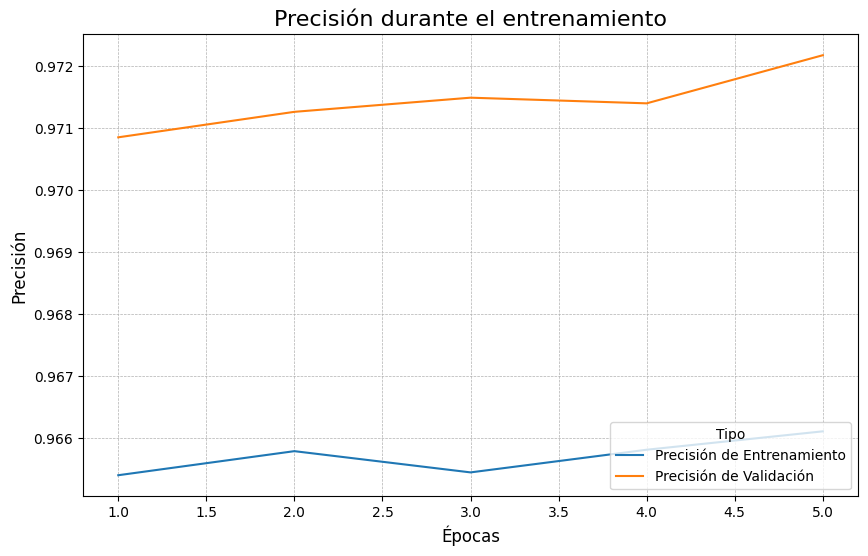

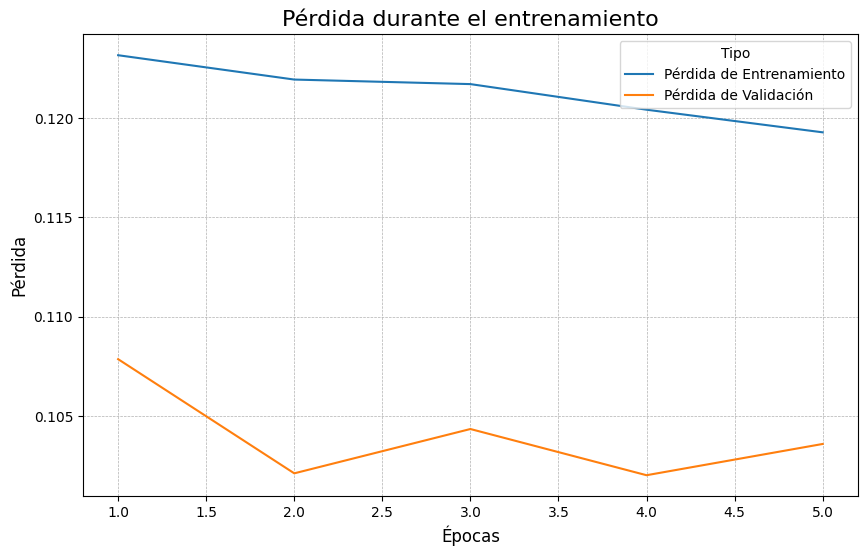

In [44]:
# Crear tablas de precisión y pérdida
def plot_metrics(history):
    # Crear un DataFrame con las métricas
    metrics_df = pd.DataFrame({
        'Época': range(1, len(history.history['accuracy']) + 1),
        'Precisión de Entrenamiento': history.history['accuracy'],
        'Precisión de Validación': history.history['val_accuracy'],
        'Pérdida de Entrenamiento': history.history['loss'],
        'Pérdida de Validación': history.history['val_loss']
    })

    # Plot de Precisión
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Época', y='value', hue='variable',
                 data=metrics_df.melt(id_vars=['Época'], value_vars=[
                     'Precisión de Entrenamiento', 'Precisión de Validación']))
    plt.title('Precisión durante el entrenamiento', fontsize=16)
    plt.xlabel('Épocas', fontsize=12)
    plt.ylabel('Precisión', fontsize=12)
    plt.legend(title='Tipo', loc='lower right')
    plt.grid(visible=True, linestyle='--', linewidth=0.5)
    plt.show()

    # Plot de Pérdida
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Época', y='value', hue='variable',
                 data=metrics_df.melt(id_vars=['Época'], value_vars=[
                     'Pérdida de Entrenamiento', 'Pérdida de Validación']))
    plt.title('Pérdida durante el entrenamiento', fontsize=16)
    plt.xlabel('Épocas', fontsize=12)
    plt.ylabel('Pérdida', fontsize=12)
    plt.legend(title='Tipo', loc='upper right')
    plt.grid(visible=True, linestyle='--', linewidth=0.5)
    plt.show()

# Llamar a la función para graficar
plot_metrics(history_extra)



2.	Definición del Modelo:

        b) Prueba 2: Modelo CNN (Red Neuronal Convolucional)

    - Implementar una CNN con capas convolucionales para extraer características espaciales de las señales.   

    - Las capas convolucionales deben incluir filtros de distintas profundidades (por ejemplo, 32, 64, 128), con funciones de activación ReLU.

    - Usar capas de Batch Normalization para estabilizar el entrenamiento y mejorar la generalización.

    - Agregar capas de MaxPooling para reducir la dimensionalidad.

    - Incluir capas Dropout para evitar el sobreajuste.

    - La capa de salida debe tener tantas neuronas como clases de arritmias, usando una función de activación softmax.

2.	Definición del Modelo:
    
        c) Prueba 3: Modelo RNN (Red Neuronal Recurrente)
        
    -	Implementar una RNN, específicamente utilizando capas LSTM, para capturar dependencias temporales en las señales de ECG.

    -	Agregar varias capas LSTM con un número adecuado de unidades y usar capas Dropout para mejorar la generalización.

    -	La capa de salida debe tener tantas neuronas como clases de arritmias, usando una función de activación softmax.

    -   Compilar el modelo usando un optimizador como Adam y categorical_crossentropy como función de pérdida. 


3.	Ajuste de Hiperparámetros y Fine-tuning:

    - Para cada modelo (ANN, CNN, RNN), ajustar el número de capas, unidades filtros por capa, tasa de aprendizaje y épocas de entrenamiento hasta obtener buenos resultados en términos de precisión.

     - En el caso de la RNN, ajustar el tamaño de la ventana temporal para captar mejor las características temporales de la señal.


4.	Evaluación y Métricas:

    -	Evaluar el desempeño de cada modelo en el conjunto de validación utilizando métricas como precisión, recall, F1-score y pérdida.

    -	Generar y analizar la matriz de confusión para observar la precisión de cada clase de arritmia.

    -	Graficar la evolución de la precisión y la pérdida durante el entrenamiento y la validación para cada modelo.


5.	Comparación y Conclusiones:

    -	Comparar los resultados obtenidos entre los modelos ANN, CNN y RNN en términos de precisión, tiempo de entrenamiento y capacidad de generalización.

    -	Evaluar si alguna de las arquitecturas proporciona una ventaja significativa en la clasificación de arritmias.

    -	Extraer conclusiones sobre cuál modelo es más adecuado para la clasificación de arritmias, proponiendo mejoras para experimentos futuros, como la implementación de técnicas de aumento de datos y el uso de arquitecturas avanzadas.
